In [113]:
import skimage
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time
import argparse
import cv2
from scipy import io
from tqdm.notebook import tqdm

import torch
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler
from pytorch_msssim import ssim

from modules import utils
from modules.models import INR

In [114]:
parser = argparse.ArgumentParser(description='INCODE')

# Shared Parameters
# parser.add_argument('--input',type=str, default='./incode_data/Image/0010.png', help='Input image path')
parser.add_argument('--input',type=str, default='./data/cameraman.jpg', help='Input image path')
parser.add_argument('--inr_model1',type=str, default='incode', help='[gauss, mfn, relu, siren, wire, wire2d, ffn, incode, parac]')
parser.add_argument('--inr_model2',type=str, default='parac', help='[gauss, mfn, relu, siren, wire, wire2d, ffn, incode, parac]')
parser.add_argument('--lr1',type=float, default=1e-4, help='Learning rate1')
parser.add_argument('--lr2',type=float, default=1e-4, help='Learning rate2')
parser.add_argument('--using_schedular', type=bool, default=True, help='Whether to use schedular')
parser.add_argument('--scheduler_b', type=float, default=0.1, help='Learning rate scheduler')
parser.add_argument('--maxpoints', type=int, default=64*64, help='Batch size')
parser.add_argument('--niters', type=int, default=301, help='Number if iterations')
parser.add_argument('--steps_til_summary', type=int, default=100, help='Number of steps till summary visualization')

# INCODE Parameters
parser.add_argument('--a_coef',type=float, default=0.1993, help='a coeficient')
parser.add_argument('--b_coef',type=float, default=0.0196, help='b coeficient')
parser.add_argument('--c_coef',type=float, default=0.0588, help='c coeficient')
parser.add_argument('--d_coef',type=float, default=0.0269, help='d coeficient')


args = parser.parse_args(args=[])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading Data

In [129]:
im = utils.normalize(plt.imread(args.input).astype(np.float32), True)
k = 2
im = cv2.resize(im, None, fx=1/k, fy=1/k, interpolation=cv2.INTER_AREA)
H, W, _ = im.shape

print(f'H: {H}, W: {W}')

H: 128, W: 128


## Defining Model

### Defining desired Positional Encoding

In [130]:
# Frequency Encoding
pos_encode_freq = {'type':'frequency', 'use_nyquist': True, 'mapping_input': int(max(H, W)/3)}

# Gaussian Encoding
pos_encode_gaus = {'type':'gaussian', 'scale_B': 10, 'mapping_input': 256}

# No Encoding
pos_encode_no = {'type': None}

### Model Configureations

In [131]:
def get_model(inr_model):
    if inr_model == 'incode':
        ### Harmonizer Configurations
        MLP_configs={'task': 'image',
                     'model': 'resnet34',
                     'truncated_layer':5,
                     'in_channels': 64,             
                     'hidden_channels': [64, 32, 4],
                     'mlp_bias':0.3120,
                     'activation_layer': nn.SiLU,
                     'GT': torch.tensor(im).to(device)[None,...].permute(0, 3, 1, 2)
                    }
        
        ### Model Configurations
        model = INR(inr_model).run(in_features=2,
                                        out_features=1, 
                                        hidden_features=256,
                                        hidden_layers=3,
                                        first_omega_0=30.0,
                                        hidden_omega_0=30.0,
                                        pos_encode_configs=pos_encode_no, 
                                        MLP_configs = MLP_configs
                                       ).to(device)

    else:
        ### Model Configurations for parac
        model = INR(inr_model).run(in_features=2,
                                        out_features=1,
                                        hidden_features=256,
                                        hidden_layers=3,
                                        first_omega_0=30.0,
                                        hidden_omega_0=30.0
                                       ).to(device)

    return model

model1 = get_model(args.inr_model1)
model2 = get_model(args.inr_model2)

## Training Code

In [132]:
def get_optim(inr_model, model, lr):
    # Optimizer setup
    if inr_model == 'wire':
        lr = lr * min(1, args.maxpoints / (H * W))
        
    optim = torch.optim.Adam(lr=lr, params=model.parameters())

    return optim
    

optim1 = get_optim(args.inr_model1, model1, args.lr1)
optim2 = get_optim(args.inr_model2, model2, args.lr2)

scheduler1 = lr_scheduler.LambdaLR(optim1, lambda x: args.scheduler_b ** min(x / args.niters, 1))
scheduler2 = lr_scheduler.LambdaLR(optim2, lambda x: args.scheduler_b ** min(x / args.niters, 1))

# Initialize lists for PSNR and MSE values
psnr_values1 = []
psnr_values2 = []

mse_array1 = torch.zeros(args.niters, device=device)
mse_array2 = torch.zeros(args.niters, device=device)

# Initialize best loss value as positive infinity
best_loss1 = torch.tensor(float('inf'))
best_loss2 = torch.tensor(float('inf'))

# Generate coordinate grid
coords = utils.get_coords(H, W, dim=2)[None, ...]

# Convert input image to a tensor and reshape
gt = torch.tensor(im).reshape(H * W, 3)[None, ...].to(device)

# Initialize a tensor for reconstructed data
rec = torch.zeros_like(gt)

In [133]:
def train_epoch(inr_model, model, optim, scheduler, best_img, best_loss, psnr_values, mse_array):
    # Randomize the order of data points for each iteration
    indices = torch.randperm(H*W)

    # Process data points in batches
    for b_idx in range(0, H*W, args.maxpoints):
        b_indices = indices[b_idx:min(H*W, b_idx+args.maxpoints)]
        b_coords = coords[:, b_indices, ...].to(device)
        b_indices = b_indices.to(device)

        # Calculate model output
        if inr_model == 'incode':
            model_output, coef = model(b_coords)
        else:
            model_output = model(b_coords)

        # Update the reconstructed data
        with torch.no_grad():
            rec[:, b_indices, :] = model_output

        # Calculate the output loss
        output_loss = ((model_output - gt[:, b_indices, :])**2).mean()

        if inr_model == 'incode':
            # Calculate regularization loss for 'incode' model
            a_coef, b_coef, c_coef, d_coef = coef[0]
            reg_loss = args.a_coef * torch.relu(-a_coef) + \
                       args.b_coef * torch.relu(-b_coef) + \
                       args.c_coef * torch.relu(-c_coef) + \
                       args.d_coef * torch.relu(-d_coef)

            # Total loss for 'incode' model
            loss = output_loss + reg_loss
        else:
            # Total loss for other models
            loss = output_loss

        # Perform backpropagation and update model parameters
        optim.zero_grad()
        loss.backward()
        optim.step()

    # Calculate PSNR
    with torch.no_grad():
        mse_array[step] = ((gt - rec)**2).mean().item()
        psnr = -10*torch.log10(mse_array[step])
        psnr_values.append(psnr.item())

    # Adjust learning rate using a scheduler if applicable
    if args.using_schedular:
        if inr_model == 'incode' and 30 < step:
            scheduler.step()
        else:
            scheduler.step()

    # Prepare reconstructed image for visualization
    imrec = rec[0, ...].reshape(H, W, 3).detach().cpu().numpy()

    # Check if the current iteration's loss is the best so far
    if (mse_array[step] < best_loss) or (step == 0):
        best_loss = mse_array[step]
        best_img = imrec
        best_img = (best_img - best_img.min()) / (best_img.max() - best_img.min())

    return best_img, best_loss, psnr, psnr_values, mse_array



  0%|          | 0/301 [00:00<?, ?it/s]

incode - Epoch: 0 | Total Loss: 0.20802 | PSNR: 6.8190
parac - Epoch: 0 | Total Loss: 0.39121 | PSNR: 4.0759


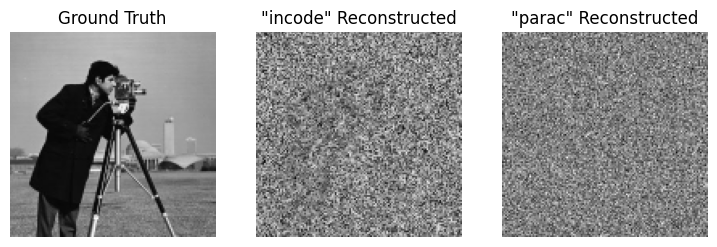

incode - Epoch: 100 | Total Loss: 0.00000 | PSNR: 79.2935
parac - Epoch: 100 | Total Loss: 0.00000 | PSNR: 91.7206


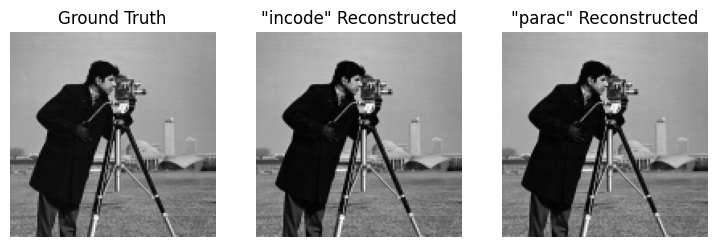

incode - Epoch: 200 | Total Loss: 0.00000 | PSNR: 111.5245
parac - Epoch: 200 | Total Loss: 0.00000 | PSNR: 108.2324


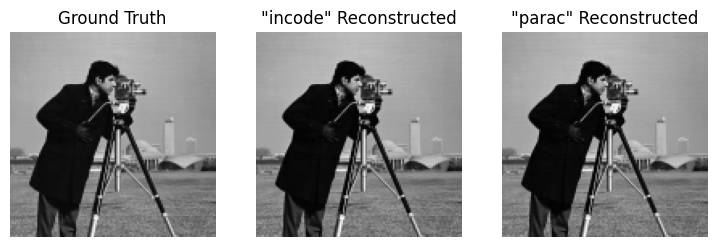

incode - Epoch: 300 | Total Loss: 0.00000 | PSNR: 122.9805
parac - Epoch: 300 | Total Loss: 0.00000 | PSNR: 110.0211


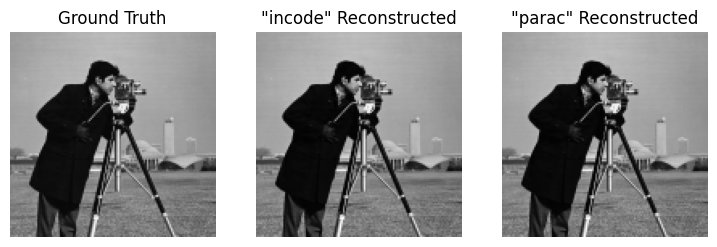

--------------------
incode Max PSNR: 123.48970031738281
parac Max PSNR: 110.02114868164062
--------------------


In [134]:
for step in tqdm(range(args.niters)):
    best_img1, best_loss1, psnr1, psnr_values1, mse_array1 = train_epoch(
        args.inr_model1, model1, optim1, scheduler1, best_img1, best_loss1, psnr_values1, mse_array1)
    best_img2, best_loss2, psnr2, psnr_values2, mse_array2 = train_epoch(
        args.inr_model2, model2, optim2, scheduler2, best_img2, best_loss2, psnr_values2, mse_array2)

    # Display intermediate results at specified intervals
    if step % args.steps_til_summary == 0:
        print(f"{args.inr_model1} - Epoch: {step} | Total Loss: {mse_array1[step].item():.5f} | PSNR: {psnr1.item():.4f}")
        print(f"{args.inr_model2} - Epoch: {step} | Total Loss: {mse_array2[step].item():.5f} | PSNR: {psnr2.item():.4f}")

        # Plot
        fig, axes = plt.subplots(1, 3, figsize=(3*3, 6))
        axes[0].set_title('Ground Truth')
        axes[0].imshow(im)
        axes[0].axis('off')
        
        axes[1].set_title(f'"{args.inr_model1}" Reconstructed')
        axes[1].imshow(best_img1)
        axes[1].axis('off')
        
        axes[2].set_title(f'"{args.inr_model2}" Reconstructed')
        axes[2].imshow(best_img2)
        axes[2].axis('off')
        
        plt.show()


# Print maximum PSNR achieved during training
print('--------------------')
print(f'{args.inr_model1} Max PSNR:', max(psnr_values1))
print(f'{args.inr_model2} Max PSNR:', max(psnr_values2))
print('--------------------')

# Convergance Rate

In [ ]:
font = {'font': 'Times New Roman', 'size': 12}

plt.figure()
axfont = {'family' : 'Times New Roman', 'weight' : 'regular', 'size'   : 10}
plt.rc('font', **axfont)

plt.plot(np.arange(len(psnr_values[:-1])), psnr_values[:-1], label = f"{(args.inr_model).upper()}")
plt.xlabel('# Epochs', fontdict=font)
plt.ylabel('PSNR (dB)', fontdict=font)
plt.title('Image Representation', fontdict={'family': 'Times New Roman', 'size': 12, 'weight': 'bold'})
plt.legend()
plt.grid(True, color='lightgray')

plt.show()